## Some Useful ffmpeg resources
https://trac.ffmpeg.org/wiki/How%20to%20speed%20up%20/%20slow%20down%20a%20video

In [1]:
import sys

import argparse
import logging
from os.path import join
logger = logging.getLogger(__name__)
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import scipy.linalg as LA
import matplotlib.pyplot as plt
sys.path.append("../scripts")

from gmm.gmm import GMM
from gmm.gaussian_reg import GMR
from cost import Cost
from config import Vxf0, options, ds_options
from stabilizer.traj_stab import stabilizer
from utils.utils import guess_init_lyap, realmin
from utils.dataloader import load_saved_mat_file
from utils.gen_utils import *
from utils.dataloader import load_saved_mat_file
from visualization.visualizer import Visualizer
from stabilizer.correct_trajos import CorrectTrajectories, check_options


In [2]:
import logging, time
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.linalg as LA
from scipy.optimize import minimize, linprog, NonlinearConstraint, BFGS
from gmm import gmm_2_parameters, parameters_2_gmm, \
                shape_DS, gmr_lyapunov
# log_level = logger.logdebug
logger = logging.getLogger(__name__)


class Cost(object):

    def __init__(self, nDemo = 1, success=True, Nfeval = 0, verbose=True):
        """
            Class that estimates lyapunov energy function

            Inputs:
                nDemo: Number of Demos for the robot
                success: Boolean indicating if optimization constraints got violated
                Nfeval: Number of function evals required for optimization to
                be rendered successful.
        """
        self.Nfeval = Nfeval
        self.success = success   # b
        self.nDemo = nDemo
        self.disp_optim_progress=verbose

    def matVecNorm(self, x):
        return np.sqrt(np.sum(x**2, axis=0))

    def obj(self, p, x, xd, d, L, w, options):
        if L == -1:  # SOS
            Vxf['n'] = np.sqrt(len(p) / d ** 2)
            Vxf['d'] = d
            Vxf['P'] = p.reshape(Vxf['n'] * d, Vxf['n'] * d)
            Vxf['SOS'] = 1
        else:
            Vxf = shape_DS(p, d, L, options)
            Vxf.update(Vxf)
        #print('Vxf.P in obj', Vxf['P'][:,:,0])
        _, Vx = self.computeEnergy(x, None, Vxf, nargout=2)
        Vdot = np.sum(Vx * xd, axis=0)  # derivative of J w.r.t. xd
        norm_Vx = np.sqrt(np.sum(Vx * Vx, axis=0))
        norm_xd = np.sqrt(np.sum(xd * xd, axis=0))
        Vdot = np.expand_dims(Vdot, axis=0)
        norm_Vx = np.expand_dims(norm_Vx, axis=0)
        norm_xd = np.expand_dims(norm_xd, axis=0)
        butt = norm_Vx * norm_xd

        # w was added by Lekan to regularize the invalid values in butt
        J = Vdot / (butt + w)
        J[np.where(norm_xd == 0)] = 0
        J[np.where(norm_Vx == 0)] = 0
        J[np.where(Vdot > 0)] = J[np.where(Vdot > 0)] ** 2
        J[np.where(Vdot < 0)] = -w * J[np.where(Vdot < 0)] ** 2
        J = np.sum(J, axis=1)
        
        return J

    def callback_opt(self, Xi, y):
        logger.debug('Iteration: {0:4d}   Cost: {1: 3.6f}'.format(self.Nfeval, y.fun[0]))
        self.Nfeval += 1

    def optimize(self, obj_handle, ctr_handle_ineq, ctr_handle_eq, p0):
        nonl_cons_ineq = NonlinearConstraint(ctr_handle_ineq, -np.inf, 0, jac='3-point', hess=BFGS())
        nonl_cons_eq = NonlinearConstraint(ctr_handle_eq, 0, 0, jac='3-point', hess=BFGS())

        logger.debug('Optimizing the lyapunov function')
        solution = minimize(obj_handle,
                            np.reshape(p0, [len(p0)]),
                            hess=BFGS(),
                            constraints=[nonl_cons_eq, nonl_cons_ineq],
                            method='trust-constr',
                            options={'disp': self.disp_optim_progress, 'initial_constr_penalty': 1.5},
                            callback=self.callback_opt)

        return solution.x, solution.fun

    def ctr_eigenvalue_ineq(self, p, d, L, options):
        # This function computes the derivative of the constrains w.r.t.
        # optimization parameters.
        Vxf = dict()
        if L == -1:  # SOS
            Vxf['d'] = d
            Vxf['n'] = int(np.sqrt(len(p) / d ** 2))
            Vxf['P'] = p.reshape(Vxf['n'] * d, Vxf['n'] * d)
            Vxf['SOS'] = 1
            c = np.zeros((Vxf['n'] * d, 1))
        else:
            Vxf = shape_DS(p, d, L, options)
            if L > 0:
                c = np.zeros(((L+1)*d+(L+1)*options['optimizePriors'], 1))  # +options.variableSwitch
            else:
                c = np.zeros((d, 1))

        if L == -1:  # SOS
            c = -np.linalg.eigvals(Vxf['P'] + Vxf['P'].T - np.eye(Vxf['n'] * d) * options['tol_mat_bias'])
        else:
            for k in range(L):                
                lambder = sp.linalg.eigvals(Vxf['P'][ :, :, k] + (Vxf['P'][ :, :, k]).T)
                lambder = np.expand_dims(lambder.real/2.0, axis=1)
                idx = slice(k*d, ((k+1)*d))
                #print(f'lambder: {lambder.shape} idx: {idx}  c: {c[idx]}')
                c[idx] = -lambder.real + options['tol_mat_bias']

        if L > 0 and options['optimizePriors']:
            idx = slice((L+1)*d, (L+1)*d+L+1)
            #print('Priors: ', {Vxf['Priors'].shape}) #, ' c[idx] ', {c[idx]})
            c[idx] = np.expand_dims(-Vxf['Priors'], 1) #np.reshape(-Vxf['Priors'], [L + 1, 1])

        return c.reshape([len(c)])

    def ctr_eigenvalue_eq(self, p, d, L, options):
        """
            This function computes the derivative of the constrains w.r.t.
            optimization parameters.
        """
        Vxf = dict()
        if L == -1:  # SOS
            Vxf['d'] = d
            Vxf['n'] = int(np.sqrt(len(p) / d ** 2))
            Vxf['P'] = p.reshape(Vxf['n'] * d, Vxf['n'] * d)
            Vxf['SOS'] = 1
            ceq = np.array(())
        else:
            Vxf = shape_DS(p, d, L, options)
            if L > 0:
                if options['upperBoundEigenValue']:
                    ceq = np.zeros((L + 1, 1))
                else:
                    ceq = np.array(())  # zeros(L+1,1);
            else:
                c = np,zeros((d, 1))
                ceq = (np.ravel(Vxf['P']).T).dot(np.ravel(Vxf['P'])) - 2

        if L == -1:  # SOS
            c = -sp.linalg.eigvals(Vxf['P'] + Vxf['P'].T - np.eye(Vxf['n']*Vxf['d'])*options['tol_mat_bias'])
        else:
            for k in range(L):
                lambder = sp.linalg.eigvals(Vxf['P'][ :, :, k] + (Vxf['P'][ :, :, k]).T)
                lambder = np.expand_dims(lambder.real/2.0, axis=1)
                if options['upperBoundEigenValue']:
                    ceq[k] = 1.0 - np.sum(lambder.real)  # + Vxf.P(:,:,k+1)'

        return ceq.reshape([len(ceq)])

    def check_constraints(self, p, ctr_handle, d, L, options):
        c = -ctr_handle(p)

        if L > 0:
            c_P = c[:L*d].reshape(d, L).T
        else:
            c_P = c

        i = np.where(c_P <= 0)
        # self.success = True

        if i:
            logger.error('Error in P constraints')
            logger.error('Eigen values of P^k violating constraints at ')
            logger.fatal('{}'.format(c_P[i]))
            self.success = False
        else:
            self.success = True

        if L > 1:
            if options['optimizePriors']:
                c_Priors = c[L*d+1:L*d+L]
                i = np.nonzero(c_Priors < 0)

                if i:
                    logger.error('Errors in constraints on priors')
                    logger.error('Values of the priors violates the constraints')
                    logger.fatal('{}'.format(c_Priors[i]))
                    self.success = False
                else:
                    self.success = True

            if len(c) > L*d+L:
                c_x_sw = c[L*d+L+1]
                if c_x_sw <= 0:
                    logger.error('error in x_sw constraints')
                    logger.fatal('c_x_sw , %f', c_x_sw)
                    self.success = False
                else:
                    self.success = True

        if self.success:
            logger.info('Optimization finished successfully')
            logger.info(' ')
        else:
            logger.warning('Optimization did not reach optimal point')
            logger.warning('Some constraints were slightly violated')
            logger.warning('Rerun the optimization w/diff initial; guesses to handle this issue')
            logger.warning('increasing the # of P could help')

    def computeEnergy(self, X, Xd, Vxf, nargout=2):
        d = X.shape[0]
        # self.nDemo = X.shape[-1]

        if self.nDemo>1:
            X = X.reshape(d,-1)
            Xd = Xd.reshape(d,-1) if np.any(Xd) else Xd

        if Vxf['SOS']:
            V, dV = sos_lyapunov(X, Vxf['P'], Vxf['d'], Vxf['n'])
            if 'p0' in Vxf:
                V -= Vxf['p0']
        else:
            V, dV = gmr_lyapunov(X, Vxf['Priors'], Vxf['Mu'], Vxf['P'])
        # if nargout > 1:
        if not Xd:
            Vdot = dV
        else:
            Vdot = np.sum(Xd*dV, axis=0)

        if self.nDemo>1:
            V = V.reshape(-1, self.nDemo).T
            Vdot = Vdot.reshape(-1, self.nDemo).T

        return V, Vdot

    def learnEnergy(self, Vxf0, Data, options):
        d = Data.shape[0]//2
        x = Data[:d, :]
        xd = Data[d:2*d, :]

        # Transform the Lyapunov model to a vector of optimization parameters
        if Vxf0['SOS']:
            p0 = npr.randn(d * Vxf0['n'], d * Vxf0['n'])
            p0 = p0@(p0.T)
            p0 = np.ravel(p0)
            Vxf0['L'] = -1  # to distinguish sos from other methods
        else:
            for l in range(Vxf0['L']):
                try:
                    Vxf0['P'][:, :, l] = sp.linalg.solve(Vxf0['P'][:, :, l], np.eye(d))
                except sp.linalg.LinAlgError as e:
                    LOGGER.debug('LinAlgError: %s', e)

            # in order to set the first component to be the closest Gaussian to origin
            idx = np.argsort(self.matVecNorm(Vxf0['Mu']), kind='mergesort')
            Vxf0['Mu'] = Vxf0['Mu'][:, idx]
            Vxf0['P'] = Vxf0['P'][:, :, idx]
            p0 = gmm_2_parameters(Vxf0, options)
            #correct
            
        obj_handle = lambda p: self.obj(p, x, xd, d, Vxf0['L'], Vxf0['w'], options)
        ctr_handle_ineq = lambda p: self.ctr_eigenvalue_ineq(p, d, Vxf0['L'], options)
        ctr_handle_eq = lambda p: self.ctr_eigenvalue_eq(p, d, Vxf0['L'], options)

        popt, J = self.optimize(obj_handle, ctr_handle_ineq, ctr_handle_eq, p0)

        if Vxf0['SOS']:
            Vxf['d']    = d
            Vxf['n']    = Vxf0['n']
            Vxf['P']    = popt.reshape(Vxf['n']*d,Vxf['n']*d)
            Vxf['SOS']  = 1
            Vxf['p0']   = self.computeEnergy(zeros(d,1),[],Vxf)
            self.check_constraints(popt,ctr_handle,d,0,options)
        else:
            # transforming back the optimization parameters into the GMM model
            Vxf             = parameters_2_gmm(popt,d,Vxf0['L'],options)
            Vxf['Mu'][:,0]  = 0
            Vxf['L']        = Vxf0['L']
            Vxf['d']        = Vxf0['d']
            Vxf['w']        = Vxf0['w']
        self.success = True

        sumDet = 0
        for l in range(Vxf['L'] + 1):
            sumDet += np.linalg.det(Vxf['P'][l, :, :])

        Vxf['P'][0, :, :] = Vxf['P'][0, :, :] / sumDet
        Vxf['P'][1:, :, :] = Vxf['P'][1:, :, :] / np.sqrt(sumDet)

        return Vxf, J


In [3]:
args = Bundle(dict(model='s'))
models = {'w': 'w.mat', 's': 'Sshape.mat'}
data, demoIdx, Priors_EM, Mu_EM, Sigma_EM = load_saved_mat_file(join('../scripts/data', models[args.model]))

Vxf0['L'] = 1 if args.model == 's' else 2
Vxf0['d'] = data.shape[0]//2
Vxf0.update(Vxf0)

Vxf0 = guess_init_lyap(data, Vxf0, options['int_lyap_random'])
cost = Cost(nDemo = 1, success=True, Nfeval = 0, verbose=False)

Vxf = cost.learnEnergy(Vxf0,data,options);

/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: divide by zero encountered in true_divide
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/ipykernel_launcher.py:276: RuntimeWarning: invalid value encountered in true_divide
/home/lex/miniconda3/envs/37/lib/python3.7/site-packages/ipykernel_launcher.py:277: RuntimeWar

In [4]:
Vxf

({'Priors': array([0.49999855, 0.50000145]),
  'Mu': array([[ 0.00000000e+00,  2.82416628e-08],
         [ 0.00000000e+00, -3.47805827e-08]]),
  'P': array([[[inf, nan],
          [inf, nan]],
  
         [[inf, nan],
          [inf, nan]]]),
  'SOS': 0,
  'L': 1,
  'd': 2,
  'w': 0.0001},
 array([7.60509432]))

In [3]:
while cost.success:
    print('Optimizing the lyapunov function')
    Vxf, J = cost.learnEnergy(Vxf0, data, options)
    old_l = Vxf0['L']
    Vxf0['L'] += 1
    print('Constraints violated. increasing the size of L from {} --> {}'.format(old_l, Vxf0['L']))
    if cost.success:
        print('optimization succeeded without violating constraints')
        break

Optimizing the lyapunov function
Constraints violated. increasing the size of L from 2 --> 3
optimization succeeded without violating constraints


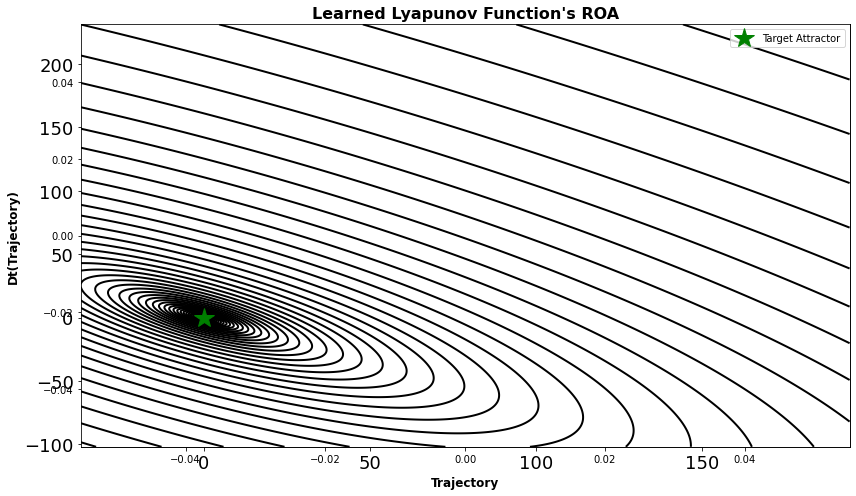

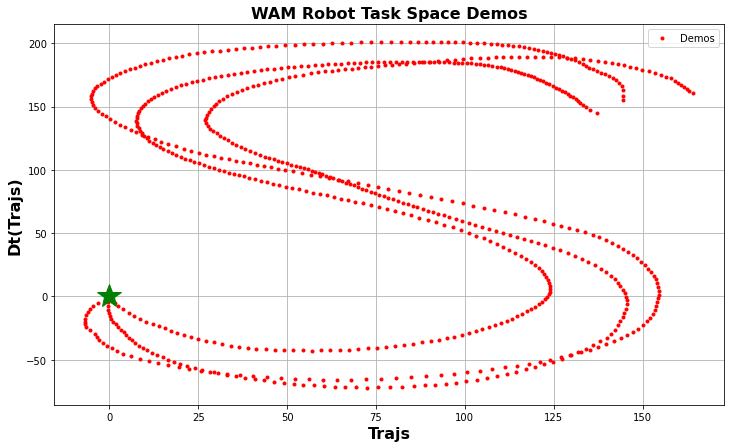

In [4]:
fontdict = {'fontsize':16, 'fontweight':'bold'}
# https://matplotlib.org/stable/users/interactive.html
plt.ion()

# fig = plt.figure(figsize=(12, 7))

savedict = dict(save=True, savename='demos_s.jpg',\
                savepath=join("..", "scripts/docs"))
viz = Visualizer(winsize=(12, 7), savedict=savedict, data=data,
                labels=['Trajs', 'Dt(Trajs)']*2, alphas = [.15]*4,
                fontdict=fontdict)

level_args = dict(disp=True, levels = [], save=True)
viz.init_demos(save=True)
# Optimize and plot the level sets of the Lyapunov function
viz.savedict["savename"]="level_sets_s.jpg"
handles = viz.level_sets(Vxf, cost, **level_args)
viz.draw()

In [142]:
__author__ 		= "Lekan Molu"
__copyright__ 	= "2018, One Hell of a Lyapunov Solver"
__credits__  	= "Rachel Thompson (MIT), Jethro Tan (PFN)"
__license__ 	= "MIT"
__maintainer__ 	= "Lekan Molu"
__email__ 		= "patlekno@icloud.com"
__status__ 		= "Testing"

import sys
import numpy as np
from utils.utils import realmin


def stabilizer(X, gmr_handle, Vxf, rho0, kappa0, **kwargs):
    """
         Syntax:

               [Xd u] = stabilizer(x,gmr_handle,Vxf,rho0,kappa0,kwargs)

         For a given (unstable) dynamical system f, this function computes a
         corrective command u such that Xd = f + u becomes globally asymptotically
         stable. Note that f could be autonomous (i.e. xd = f(x)) or
         non-autonomous (i.e. xd = f(t,x)).

         Inputs -----------------------------------------------------------------
           o X:       If f is an autonomous DS, then X is d by N matrix
                      representing N different query point(s) (each column of X
                      corresponds to each query point). If f is a non-autonomous
                      function, then X is a (d+1) by N matrix. In this case the
                      last row of X corresponds to time, for example X(d+1,10)
                      corresponds to the time at the 10th query point.

           o gmr_handle: This is a function handle that evaluates either f(t,x) or
                        f(x).

           o Vxf:     A structure variable representing the energy function. This
                      structure should follow the format explained in learnEnergy.m

           o rho0, kappa0: These parameters impose minimum acceptable rate of decrease
                           in the energy function during the motion. It computes
                           this lower bound from the following class \mathcal{K}
                           function:
                                   rho(\|x\|) = rho0 * ( 1 - exp(-kappa0 * \|x\|) )
                           Please refer to page 8 of the paper for more information.

           o kwargs:  An optional variable that provides dt (integration time
                        step) to the function, i.e. kwargs{1} = dt, dt>0.
                        Providing dt is useful, especially when using large
                        integration time step. Note that our whole stability proof
                        is based on continuous space assumption. When using large
                        time step, the effect of discretization become more
                        dominant and could cause oscillation. Bt providing dt, we
                        could alleviate this issue.

         Outputs ----------------------------------------------------------------

           o Xd:       A d x N matrix providing the output velocity after stabilization,
                       i.e. Xd = f + u

           o u:        A d x N matrix corresponding to the stabilizing command that
                       were generated to ensure stability of the dynamical system.
                       When u(:,i) = 0, it means the function f is stable by
                       itself at that query point, and no stabilizing command was
                       necessary. Note: we provide u as an output just for
                       information, you do NOT need to add it to the output
                       velocity!

        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        %%%         Copyright (c) 2014 Mohammad Khansari, LASA Lab, EPFL,       %%%
        %%%          CH-1015 Lausanne, Switzerland, http://lasa.epfl.ch         %%%
        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

         The program is free for non-commercial academic use. Please contact the
         author if you are interested in using the software for commercial purposes.
         The software must not be modified or distributed without prior permission
         of the authors. Please acknowledge the authors in any academic publications
         that have made use of this code or part of it. Please use this BibTex
         reference:

         S.M. Khansari-Zadeh and A. Billard (2014), "Learning Control Lyapunov Function
         to Ensure Stability of Dynamical System-based Robot Reaching Motions."
         Robotics and Autonomous Systems, vol. 62, num 6, p. 752-765.

         To get latest update of the software please visit
                                  http://cs.stanford.edu/people/khansari/

         Please send your feedbacks or questions to:
                                  khansari_at_cs.stanford.edu
    """
    if not 'cost' in kwargs:
        error('User must supply the Control Lyapunov Function Cost.')
    cost = kwargs['cost']

    # print('X ', X)
    d = Vxf['d']
    if X.shape[0] == 2*d:
        Xd = X[d:2*d, :]
        X = X[:d, :]
    else:
        if 'time_varying' in kwargs and not kwargs['time_varying']:
            Xd, _, _ = gmr_handle(X)
        elif 'time_varying' and kwargs['time_varying']:
            t = X[d,:]
            X = X[d,:]
            Xd, _, _ = gmr_handle(t,X)
        else:
            disp('Unknown GMR function handle!')
            return

    V, Vx = cost.computeEnergy(X, np.array(()), Vxf)
    print(f'V: {V}, Vx: {Vx}')
    norm_Vx = np.sum(Vx**2, axis=0)
    norm_x = np.sum(X**2, axis=0)

    Vdot = np.sum(Vx * Xd, axis=0)
    rho = rho0 * (1-np.exp(-kappa0 * norm_x)) * np.sqrt(norm_Vx)

    print(f'Vdot: {Vdot}, rho: {rho}')
#     import time
#     time.sleep(5)
    ind = np.nonzero((Vdot + rho)>=0)[0] # not sure of this indexing
    print(f'ind: {ind}')
    u = np.zeros_like(Xd, dtype=np.float64)
    print()

    if np.sum(ind) > 0:
        lambder = np.expand_dims(np.divide(Vdot[ind] + rho[ind], norm_Vx[ind]), 0) #+ realmin) # sys issues bruh)
        # print(f'u[:, ind]: {u[:, ind].shape}, np.tile(lambder, [d, 1]): \
        #         {np.tile(lambder, [d, 1]).shape}, Vx: {Vx[:, ind].shape}')
        u[:, ind] = -np.tile(lambder, [d, 1]) * np.squeeze(Vx[:, ind])
        Xd[:, ind] = Xd[:, ind] + u[:, ind]

    if 'dt' in kwargs:
        dt = kwargs['dt']
        Xn = X + np.dot(Xd, dt)
        Vn = cost.computeEnergy(Xn, np.array(()), Vxf)
        ind = (Vn >= V)
        i = 0

        while np.any(ind) and i < 10:
            alpha = V[ind]/Vn[ind]
            Xd[:,ind] = np.tile(alpha, [d, 1]) * Xd[:, ind] - \
                        np.tile(alpha * np.sum(Xd[:, ind] * \
                        Vx[:, ind], axis=0)/norm_Vx[ind], [d, 1])*Vx[:, ind]
            Xn = x + np.dot(Xd, dt)
            Vn = cost.computeEnergy(Xn, np.array(()), Vxf)
            ind = Vn >= V
            i = i + 1

    return Xd, u

In [143]:
rho0 = 1.0
kappa0 = 0.1

traj = list(range(Vxf['d']))
traj_derivs = np.arange(Vxf['d'], 2 * Vxf['d'])
mu, sigma, priors = Mu_EM, Sigma_EM, Priors_EM

"Now stabilize the learned dynamics"
traj = np.arange(Vxf['d'], dtype=np.intp) #slice(0, Vxf['d']) #
traj_derivs = np.arange(Vxf['d'], 2 * Vxf['d'], dtype=np.intp) #slice(Vxf['d'], 2 * Vxf['d']) # 
Xinit = data[:Vxf['d'], demoIdx[0, :-1]]

cost_stab = Cost(nDemo = 1, success=True, Nfeval = 0, verbose=False)
stab_args = {'time_varying': False, 'cost': cost_stab}
gmr_handle = lambda x: GMR(priors, mu, sigma, x, traj, traj_derivs)
stab_handle = lambda x: stabilizer(x, gmr_handle, Vxf, rho0, kappa0, **stab_args) #, priors, mu, sigma

In [144]:
x, xdot, _, _, _ = CorrectTrajectories(Xinit, [], stab_handle, Bundle(ds_options))

V: [1.77953090e+09 2.26094449e+09 3.08405764e+09], Vx: [[23655168.4783114  28283406.56787033 35943599.26488991]
 [26672554.07243888 31942649.97616703 40078731.76472534]]
Vdot: [4.26078285e+08 4.25801251e+08 6.33217659e+08], rho: [35650976.65540838 42664786.11903936 53835370.04594469]
ind: [0 1 2]

x: (2, 3), V: [1.77917475e+09 2.26051830e+09 3.08351998e+09], Vx: [[23648697.42623854 28275869.39063453 35934394.68298846]
 [26671302.43543684 31941429.22774559 40078099.4660665 ]]
Vdot: [4.23896807e+08 4.23029209e+08 6.29226586e+08], rho: [35645746.78079168 42658875.87486692 53828754.1936901 ]
ind: [0 1 2]

x: (2, 3), V: [1.77881865e+09 2.26009217e+09 3.08298237e+09], Vx: [[23642227.46313697 28268333.35621756 35925191.12775229]
 [26670045.8772701  31940202.60887179 40077458.77551492]]
Vdot: [4.21717677e+08 4.20260069e+08 6.25239609e+08], rho: [35640514.39744381 42652962.53994583 53822133.54623383]
ind: [0 1 2]

x: (2, 3), V: [1.77846261e+09 2.25966610e+09 3.08244484e+09], Vx: [[23635758.5906

ValueError: too many values to unpack (expected 5)

In [145]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])